In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from scipy import signal
from scipy.stats import multivariate_normal
import scipy
from skimage import color

In [0]:
data_path = ""

In [0]:
flower = mpimg.imread(data_path+"flower.jpg")
H, W, C = flower.shape

In [0]:
flower = flower.reshape(-1,3)  # reshape to two dimensional array
flower = flower / flower.max() # normalize intensity values to 0-1

# 1. Expectation Maximization

## 1.1 Fit Gaussian Mixture Model

In [0]:
def GMM(x, num_seg=2, max_iter=100, random_seed=10):
  # x: input feature matrix - shape: (num_examples, num_features)
  # num_seg: total number of segmentation classes
  # max_iter: number of maximum iteration for EM.
  # random_seed: random_seed to keep model deterministic
  # EM stops either at maximum iterations or when there is no change in label assignments after two consecutive iterations
  
  np.random.seed(random_seed)

  num_features = x.shape[-1]
  num_examples = x.shape[0]

  # Initialize random parameter values
  mu = x[np.random.randint(0,num_examples,num_seg),:]         # initialize random mu - shape: (num_seg, num_features)
  cov = np.random.random((num_seg,num_features,num_features)) # intialize random convariance matrix - shape: (num_seg, num_features, num_features)
  cov = np.einsum('ijk,ikl->ijl', cov, cov.transpose(0,2,1))  # make sure that cov matrices are positive semi-definite
  alpha = np.random.random((num_seg,))                        # initialize random alpha - shape: (num_seg,)
  y_soft = np.zeros((num_seg,num_examples))                   # initialize y_soft to store probability of each example belonging to each segment - shape: (num_seg, num_examples)
  y_hard = np.zeros((num_examples))                           # initialize y_hard to store single estimation for each example: - shape (num_examples,)

  # calculate total Parameters of the model
  mean_parameters = num_features * num_seg
  cov_parameters = num_seg * num_features * (num_features + 1) / 2
  alpha_parameters = num_seg
  total_parameters = mean_parameters + cov_parameters + alpha_parameters
  
  # Iterate Through EM steps
  for itr in range(max_iter+1):
    
    # Expectation Step
    for i in range(num_seg):
      y_soft[i] = multivariate_normal.pdf(x, mean=mu[i], cov=cov[i]) * alpha[i]

    p_x_t = np.sum(y_soft,0)
    y_soft = y_soft / p_x_t

    y = np.argmax(y_soft,0)

    # check if there is any change in label assignment
    if np.array_equal(y,y_hard):
      break
    else:
      y_hard = np.copy(y)
    
    # Maximization Step (Parameter Estimation)
    for i in range(num_seg):
      alpha[i] = np.mean(y_soft[i])
      mu[i] = np.sum(x.transpose()*y_soft[i],-1) / np.sum(y_soft[i])
      cov[i] = np.cov(x.transpose(), aweights=y_soft[i])
  
  
  # calculate BIC score
  bic = (-2.0 * np.log(p_x_t).sum()) + (total_parameters * np.log(num_examples))

  return y_hard, bic
  

### GMM segmentation for different value of *m*

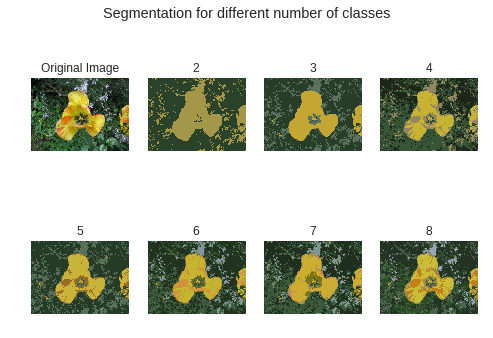

In [8]:
max_num_seg = 8

plt.subplot(2,max_num_seg//2,1)
plt.imshow(flower.reshape((H,W,C)).astype('float'))
plt.axis('off')
plt.title('Original Image')

for m in range(2,max_num_seg+1):
  y_seg, _ = GMM(flower, m, max_iter=20)
  
  img = flower.reshape((H,W,C)).astype('float')
  y_seg = y_seg.reshape((H,W)).astype('float')
  
  plt.subplot(2,max_num_seg//2,m)
  plt.imshow(color.label2rgb(y_seg,img, kind='avg'))
  plt.axis('off')
  plt.title('{}'.format(m))

plt.suptitle('Segmentation for different number of classes')
plt.show()  

In [0]:
# save segmentation with num_seg = 2
y_seg, _ = GMM(flower, 2)

mpimg.imsave(data_path+'seg_2.jpg',y_seg.reshape((H,W)).astype('float'))



### Model Selection

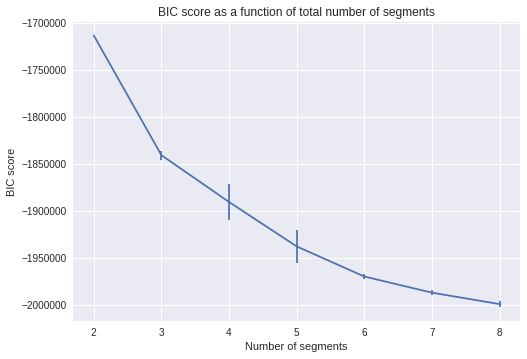

In [10]:
# calculate BIC score for m={2,3,..,8} with 5 different random initialization 
num_rand_init = 5
bic_scores = np.zeros((max_num_seg,num_rand_init))

for r in range(num_rand_init):
  for m in range(2,max_num_seg+1):
     _, bic_scores[m-1,r] = GMM(flower,m,random_seed=r)

bic_mean_scores = np.mean(bic_scores,1)
bic_std_scores = np.std(bic_scores,1)

x = np.arange(1,max_num_seg+1)
plt.errorbar(x[1::], bic_mean_scores[1::], bic_std_scores[1::])
plt.title("BIC score as a function of total number of segments")
plt.xlabel('Number of segments')
plt.ylabel('BIC score')
plt.show()

We can see that, mean BIC scores decrease with increase in number of labels. Ideally, we want to use **m** where BIC score is minimum  or where the graph creats and angle. But we can see that segmentation for m=8 is not good. 
